# Introduction to the MNIST database

In the following tutorials, we are going to use the MNIST database of handwritten digits. MNIST is a simple computer vision dataset of handwritten digits. It has 60,000 training examles and 10,000 test examples. "It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting." For more details of this database, please checkout the [MNIST](http://yann.lecun.com/exdb/mnist/) website.

Let's start our experiment by importing some necessary packages and initializing the engine first.

In [1]:
import matplotlib
matplotlib.use('Agg')
# As always, a bit of setup
%pylab inline
import pandas
from bigdl.dataset import mnist
from bigdl.util.common import *
import matplotlib.pyplot as plt
from pyspark import SparkContext
from matplotlib.pyplot import imshow

sc=SparkContext.getOrCreate(conf=create_spark_conf().setMaster("local[4]").set("spark.driver.memory","2g"))
init_engine()

Populating the interactive namespace from numpy and matplotlib


In BigDL, we have already provided a utility method called *mnist.read_data_sets* to download and read the MNIST data into memory as numpy ndarray.

In [3]:
mnist_path = "datasets/mnist"
(train_images, train_labels) = mnist.read_data_sets(mnist_path, "train")
(test_images, test_labels) = mnist.read_data_sets(mnist_path, "test")

print (train_images.shape)
print (train_labels.shape)
print (test_images.shape)
print (test_labels.shape)

9846784/9912422 [============================>.] - ETA: 0sSuccessfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting datasets/mnist/train-images-idx3-ubyte.gz
 8192/28881 [=======>......................] - ETA: 0sSuccessfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting datasets/mnist/train-labels-idx1-ubyte.gz
1556480/1648877 [===========================>..] - ETA: 0sSuccessfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting datasets/mnist/t10k-images-idx3-ubyte.gz
8192/4542 [======================================================] - 0s
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting datasets/mnist/t10k-labels-idx1-ubyte.gz
(60000, 28, 28, 1)
(60000,)
(10000, 28, 28, 1)
(10000,)


The training set consists of 60,000 examples and the test set consits of 10,000 examples. Each example is a 28x28 pixel image represting a handwritten digit. Let's see some first ten examples and their labels.

groud true labels: 
[5 0 4 1 9 2 1 3 1 4]


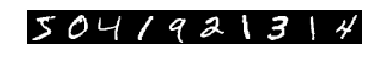

In [4]:
imshow(np.column_stack(train_images[0:10].reshape(10, 28,28)),cmap='gray'); plt.axis('off')
print ("groud true labels: ")
print (train_labels[0:10])

To use mnist dataset in Bigdl, we have to transform the ndarrays to rdd of Sample. And since neural networks tend to work better with zero-mean and unit variance data, we'd better normalize the images before fed into the model. We created a small utility method called `get_mnist` for you to simplify the standardization process. You can find it in the *utils.py* file under the same directory of this notebook. For convenience, we'll just put the code here to review the code quickly.

In [5]:
def get_mnist(sc, mnist_path):
    # target is start from 0,
    (train_images, train_labels) = mnist.read_data_sets(mnist_path, "train")
    (test_images, test_labels) = mnist.read_data_sets(mnist_path, "test")
    training_mean = np.mean(train_images)
    training_std = np.std(train_images)
    rdd_train_images = sc.parallelize(train_images)
    rdd_train_labels = sc.parallelize(train_labels)
    rdd_test_images = sc.parallelize(test_images)
    rdd_test_labels = sc.parallelize(test_labels)
    
    rdd_train_sample = rdd_train_images.zip(rdd_train_labels).map(lambda kv:
                    Sample.from_ndarray((kv[0] - training_mean)/training_std, kv[1] + 1))
    rdd_test_sample = rdd_test_images.zip(rdd_test_labels).map(lambda kv:
                    Sample.from_ndarray((kv[0] - training_mean)/training_std, kv[1] + 1))
    return (rdd_train_sample, rdd_test_sample)


In [7]:
(train_data, test_data) = get_mnist(sc, mnist_path)
print (train_data.count())
print (test_data.count())

Extracting datasets/mnist/train-images-idx3-ubyte.gz
Extracting datasets/mnist/train-labels-idx1-ubyte.gz
Extracting datasets/mnist/t10k-images-idx3-ubyte.gz
Extracting datasets/mnist/t10k-labels-idx1-ubyte.gz
60000
10000


The function *get_minst()* is very useful and we write it to a file named *utils.py*. It will be imported in later tutorials.